In [1]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn.functional as F

from torch import nn
from torch.autograd import Variable
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")

# set SEED
os.environ["SEED"] = "42"

In [2]:
os.getcwd()

'd:\\DataScience_For_mySelf\\Projects_myself\\MLOPs\\guide-mlops\\anomaly_detection_in_transactions\\notebooks'

In [3]:
file_path = "../../../datasets/metaverse_transactions_dataset.csv"
data = pd.read_csv(file_path)
data

,timestamp,hour_of_day,sending_address,receiving_address,amount,transaction_type,location_region,ip_prefix,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
0,2022-04-11 12:47:27,12,0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da,0x39f82e1c09bc6d7baccc1e79e5621ff812f50572,796.949206,transfer,Europe,192.000,3,48,focused,established,18.7500,low_risk
1,2022-06-14 19:12:46,19,0xd6e251c23cbf52dbd472f079147873e655d8096f,0x51e8fbe24f124e0e30a614e14401b9bbfed5384c,0.010000,purchase,South America,172.000,5,61,focused,established,25.0000,low_risk
2,2022-01-18 16:26:59,16,0x2e0925b922fed01f6a85d213ae2718f54b8ca305,0x52c7911879f783d590af45bda0c0ef2b8536706f,778.197390,purchase,Asia,192.168,3,74,focused,established,31.2500,low_risk
3,2022-06-15 09:20:04,9,0x93efefc25fcaf31d7695f28018d7a11ece55457f,0x8ac3b7bd531b3a833032f07d4e47c7af6ea7bace,300.838358,transfer,South America,172.000,8,111,high_value,veteran,36.7500,low_risk
4,2022-02-18 14:35:30,14,0xad3b8de45d63f5cce28aef9a82cf30c397c6ceb9,0x6fdc047c2391615b3facd79b4588c7e9106e49f2,775.569344,sale,Africa,172.160,6,100,high_value,veteran,62.5000,moderate_risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78595,2022-02-13 12:52:27,12,0xa99b9a7f5c5dd37429771efd3b93c6fbe1ab2936,0x5a78c88c5fc1e9b512f6c64e266b46a9db0a7238,660.280373,transfer,Africa,172.000,1,27,random,new,26.2500,low_risk
78596,2022-02-16 16:15:29,16,0xcca095ad2d508c200bda1141f783d77c3e6cbb08,0xb71a4df291ea8e9996a74e77ab63f5abcbfe90f5,310.273397,purchase,Africa,172.000,5,60,focused,established,26.2500,low_risk
78597,2022-08-04 16:06:42,16,0xe0b340171486b08f0c1f4ac607ed776478cefd2b,0x577754308538f4be10a41afb4f8900cd24d7098f,624.674332,purchase,Africa,192.000,1,34,random,new,36.7500,low_risk
78598,2022-02-26 04:06:08,4,0xb0b2f6fc707fbb7f9d27a9f4fe0cb0d6b39a0155,0xd6ba299fdd52f09f01d9648036ca446498c01ac2,401.391592,purchase,Asia,192.168,4,56,focused,established,35.4375,low_risk


In [4]:
data.isnull().sum()

timestamp            0
hour_of_day          0
sending_address      0
receiving_address    0
amount               0
transaction_type     0
location_region      0
ip_prefix            0
login_frequency      0
session_duration     0
purchase_pattern     0
age_group            0
risk_score           0
anomaly              0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78600 entries, 0 to 78599
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          78600 non-null  object 
 1   hour_of_day        78600 non-null  int64  
 2   sending_address    78600 non-null  object 
 3   receiving_address  78600 non-null  object 
 4   amount             78600 non-null  float64
 5   transaction_type   78600 non-null  object 
 6   location_region    78600 non-null  object 
 7   ip_prefix          78600 non-null  float64
 8   login_frequency    78600 non-null  int64  
 9   session_duration   78600 non-null  int64  
 10  purchase_pattern   78600 non-null  object 
 11  age_group          78600 non-null  object 
 12  risk_score         78600 non-null  float64
 13  anomaly            78600 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.4+ MB


### Dataset Overview:
0   timestamp           :   Date and time of the transaction.  
 1   hour_of_day        :   Hour part of the transaction timestamp. 
 2   sending_address    :   Blockchain address of the sender.   
 3   receiving_address  :   Blockchain address of the receiver. 
 4   amount             :   Transaction amount in a simulated currency. 
 5   transaction_type   :   Categorization of the transaction (e.g., transfer, sale, purchase, scam, phishing). 
 6   location_region    :   Simulated geographical region of the transaction.   
 7   ip_prefix          :   Simulated IP address prefix for the transaction.    
 8   login_frequency    :   Frequency of login sessions by the user, varying by age group.  
 9   session_duration   :   Duration of activity sessions in minutes.   
 10  purchase_pattern   :   Behavioral pattern of purchases (e.g., focused, random, high-value).    
 11  age_group          :   Categorization of users into new, established, and veteran based on their activity history. 
 12  risk_score         :   Calculated risk score based on transaction characteristics and user behavior.   
Anomaly:  
 13  anomaly            : Risk level assessment (e.g., high_risk, moderate_risk, low_risk). 
Usage - Target for this project ()

KNN	Fast outlier detection in high dimensional spaces
LOF	LOF: identifying density-based local outliers	
IForest	Isolation forest	
OCSVM	Estimating the support of a high-dimensional distribution
AutoEncoder Ensemble



Graph-Augmented Normalizing Flows for Anomaly Detection of Multiple Time Series	ICLR
Drift doesn't matter: dynamic decomposition with diffusion reconstruction for unstable multivariate time series anomaly detection


MAD-GAN: Multivariate Anomaly Detection for Time Series Data with Generative Adversarial Networks


## Data Processing

In [6]:
data.columns

Index(['timestamp', 'hour_of_day', 'sending_address', 'receiving_address',
       'amount', 'transaction_type', 'location_region', 'ip_prefix',
       'login_frequency', 'session_duration', 'purchase_pattern', 'age_group',
       'risk_score', 'anomaly'],
      dtype='object')

In [7]:
data_processed = data.copy()
data_processed = data_processed.drop([ 'sending_address', 'receiving_address', 'ip_prefix'], axis = 1) 
data_processed.head()

,timestamp,hour_of_day,amount,transaction_type,location_region,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
0,2022-04-11 12:47:27,12,796.949206,transfer,Europe,3,48,focused,established,18.75,low_risk
1,2022-06-14 19:12:46,19,0.010000,purchase,South America,5,61,focused,established,25.00,low_risk
2,2022-01-18 16:26:59,16,778.197390,purchase,Asia,3,74,focused,established,31.25,low_risk
3,2022-06-15 09:20:04,9,300.838358,transfer,South America,8,111,high_value,veteran,36.75,low_risk
4,2022-02-18 14:35:30,14,775.569344,sale,Africa,6,100,high_value,veteran,62.50,moderate_risk


In [8]:
## Sorted by timestamp
data_processed['timestamp']=pd.to_datetime(data_processed['timestamp'])
data_processed = data_processed.sort_values('timestamp', ascending=True)
data_processed

,timestamp,hour_of_day,amount,transaction_type,location_region,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
62869,2022-01-01 00:00:45,0,592.024530,transfer,South America,6,84,high_value,veteran,49.6125,low_risk
41882,2022-01-01 00:12:24,0,755.500717,transfer,North America,3,70,focused,established,25.3125,low_risk
31457,2022-01-01 00:14:54,0,247.716361,transfer,Asia,5,54,focused,established,20.2500,low_risk
18364,2022-01-01 00:27:12,0,422.789709,purchase,North America,4,62,focused,established,35.4375,low_risk
3359,2022-01-01 00:36:27,0,353.949174,sale,South America,7,94,high_value,veteran,70.8750,moderate_risk
...,...,...,...,...,...,...,...,...,...,...,...
28762,2022-12-31 23:25:21,23,239.989984,transfer,South America,1,31,random,new,25.0000,low_risk
34614,2022-12-31 23:36:26,23,418.844574,transfer,North America,6,139,high_value,veteran,36.7500,low_risk
40329,2022-12-31 23:41:28,23,391.235270,transfer,Europe,8,88,high_value,veteran,36.7500,low_risk
62686,2022-12-31 23:46:47,23,542.983002,sale,Africa,7,112,high_value,veteran,52.5000,low_risk


In [9]:
# Get Categorical Features
categories_df = data_processed.select_dtypes(include=["object"], exclude=["int64", "float64"])
# Get Numeric Features
numerical_df = data_processed.select_dtypes(exclude=["object"], include=["int64", "float64"])
print(categories_df.head())
print(numerical_df.head())

      transaction_type location_region purchase_pattern    age_group  \
62869         transfer   South America       high_value      veteran   
41882         transfer   North America          focused  established   
31457         transfer            Asia          focused  established   
18364         purchase   North America          focused  established   
3359              sale   South America       high_value      veteran   

             anomaly  
62869       low_risk  
41882       low_risk  
31457       low_risk  
18364       low_risk  
3359   moderate_risk  
       hour_of_day      amount  login_frequency  session_duration  risk_score
62869            0  592.024530                6                84     49.6125
41882            0  755.500717                3                70     25.3125
31457            0  247.716361                5                54     20.2500
18364            0  422.789709                4                62     35.4375
3359             0  353.949174         

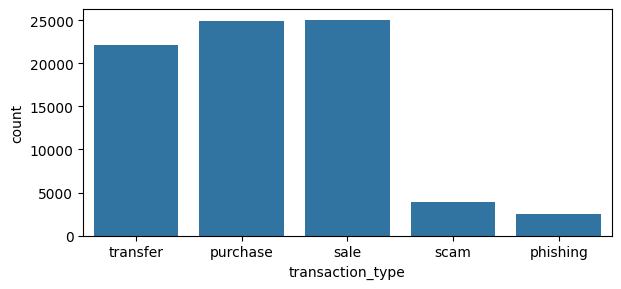

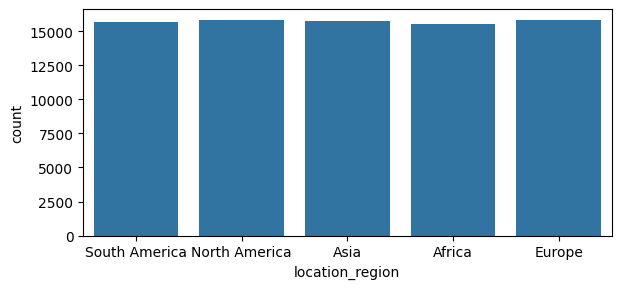

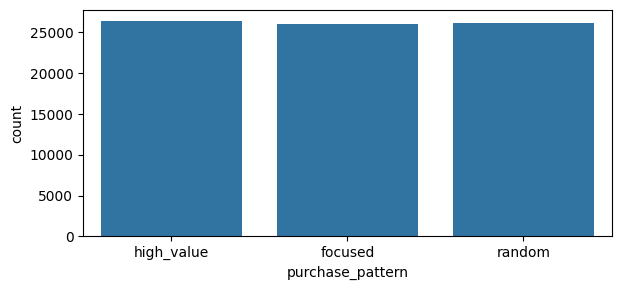

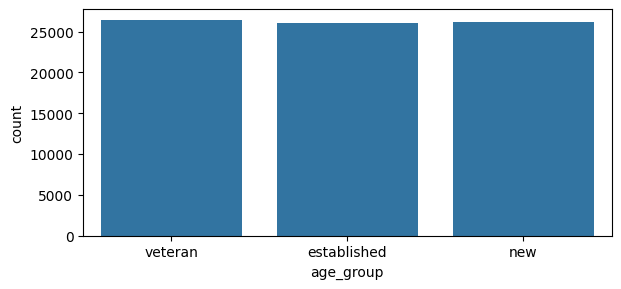

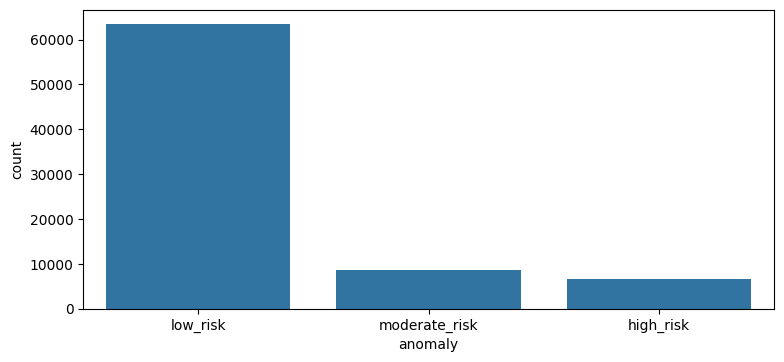

In [10]:
### Visualization of Categorical Features
row_cat_number = 3
col_cat_number = 2
it = 1

for cat_col in categories_df.columns:
    plt.figure(figsize=(15, 10))
    plt.subplot(row_cat_number, col_cat_number, it)
    sns.countplot(x=cat_col, data=categories_df)
    it = it + 1

plt.tight_layout()
plt.show()

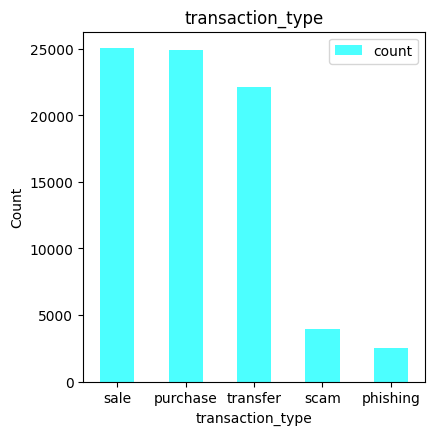

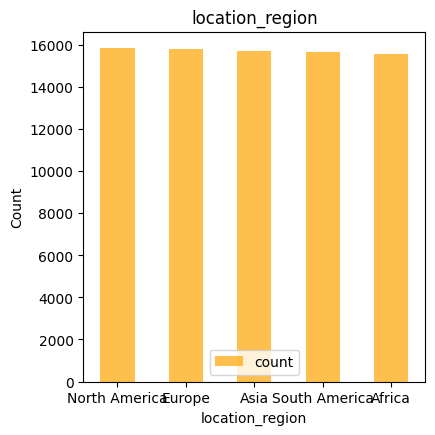

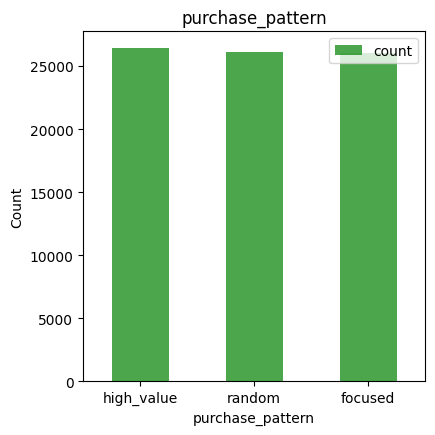

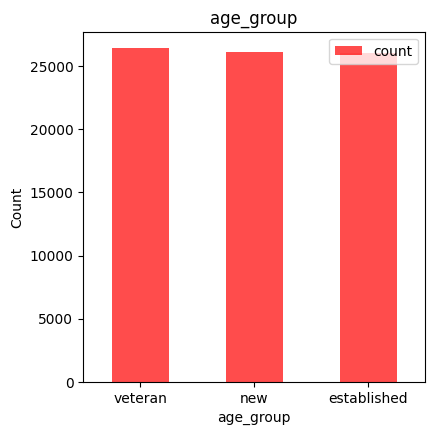

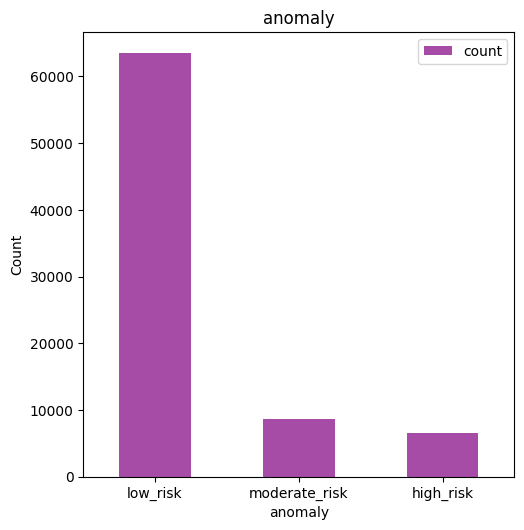

In [11]:
row_cat_number_bar = 2
col_cat_number_bar = 3
it = 1
color_list = ["cyan", "orange", "green", "red", "purple"]
for cat_col in categories_df.columns:
    plt.figure(figsize=(15, 10))
    plt.subplot(row_cat_number_bar, col_cat_number_bar, it)
    categories_df[cat_col].value_counts().plot(kind="bar", 
                                               title=cat_col, 
                                               color=color_list[it-1], 
                                               alpha=0.7, 
                                               rot=0,
                                               )
    plt.legend()
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.title(cat_col)
    

    it = it + 1

plt.tight_layout()
plt.show()

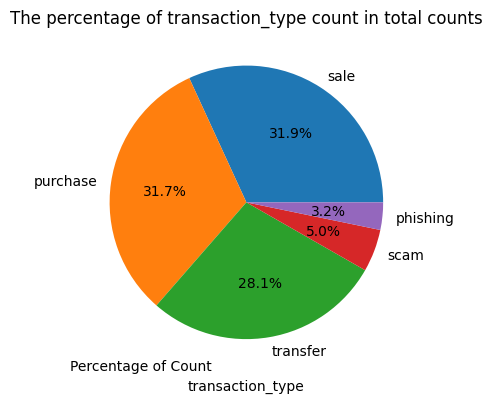

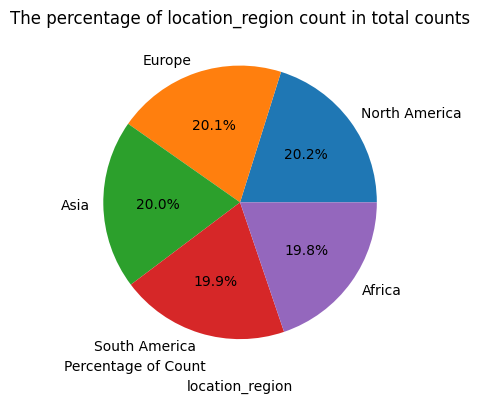

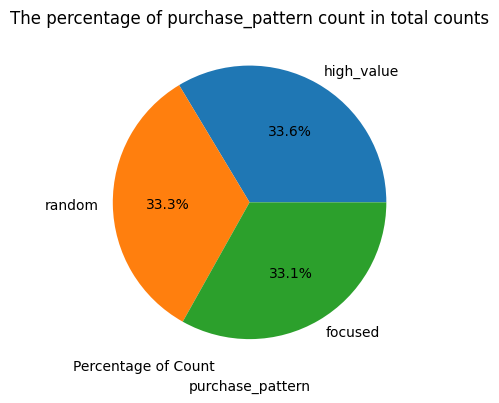

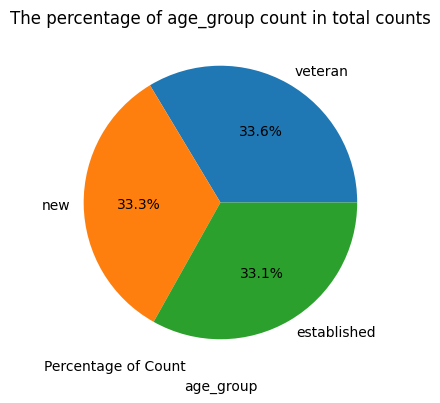

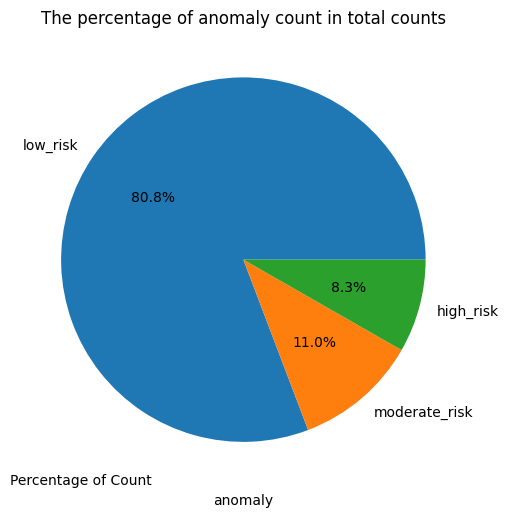

In [12]:
row_cat_number_pie = 2
col_cat_number_pie = 3
it = 1

color_list = ["cyan", "orange", "green", "red", "purple"]
for cat_col in categories_df.columns:
    plt.figure(figsize=(15, 10))
    plt.subplot(row_cat_number_pie, col_cat_number_pie, it)
    categories_df[cat_col].value_counts().plot(kind="pie", 
                                               title=cat_col,
                                               autopct="%1.1f%%",
                                               color=color_list[it-1],

                                              )
    it = it + 1
    plt.title(f"The percentage of {cat_col} count in total counts")
    plt.xlabel(cat_col)
    plt.ylabel("Percentage of Count", loc = "bottom", rotation=0)
    plt.yticks(rotation=90, ha="left")


plt.tight_layout()
plt.show()

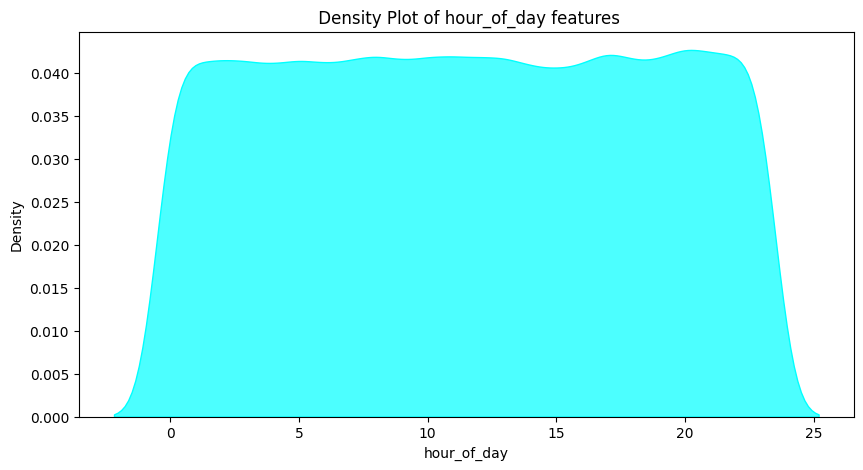

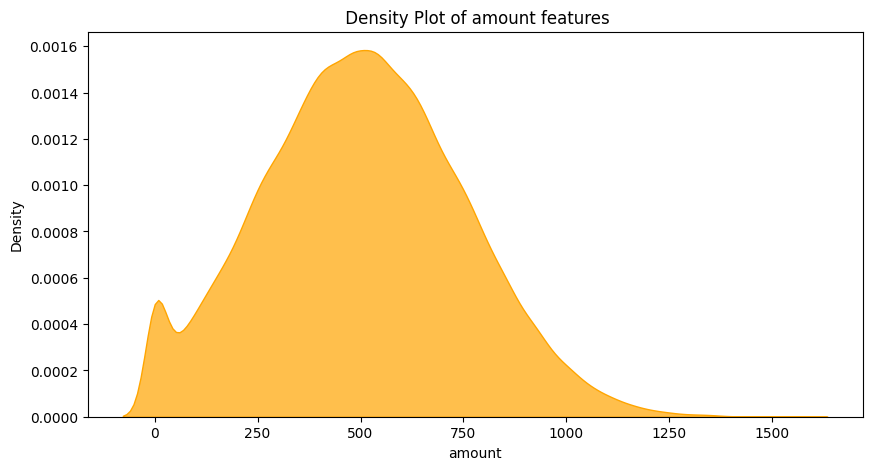

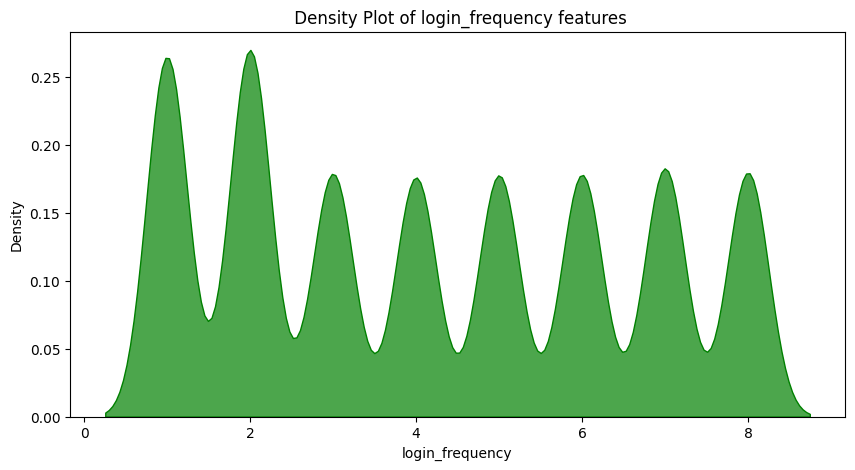

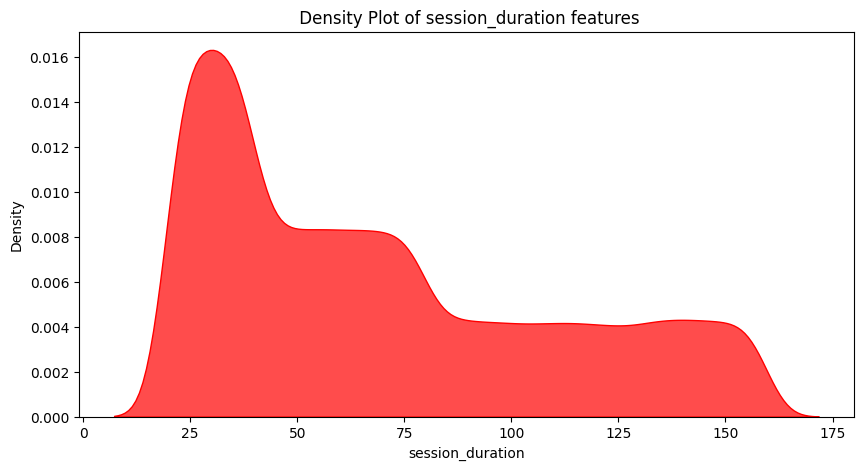

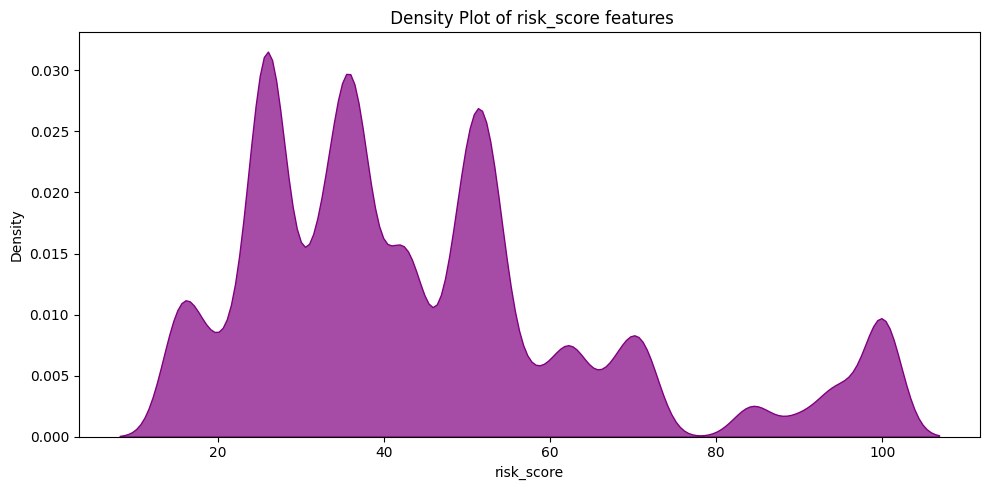

In [13]:
### Visualization of Numerical Features
row_num_number = 3
col_num_number = 2
it = 1

for num_col in numerical_df.columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(x=num_col, data=numerical_df, fill=True, color=color_list[it-1], alpha=0.7)
    plt.title(f" Density Plot of {num_col} features")
    plt.xlabel(num_col)
    plt.ylabel("Density")


    it = it + 1

plt.tight_layout()
plt.show()

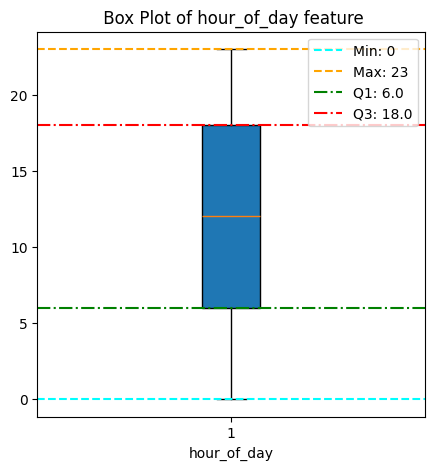

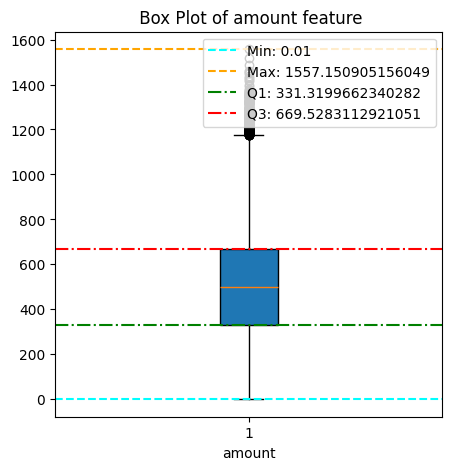

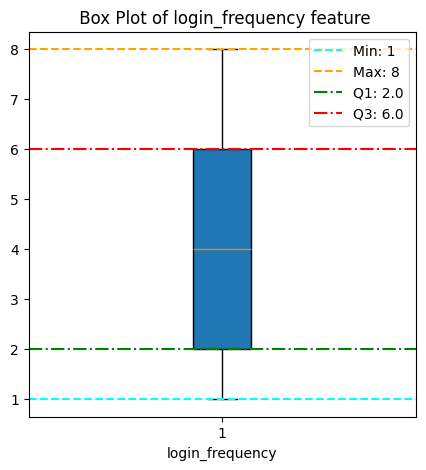

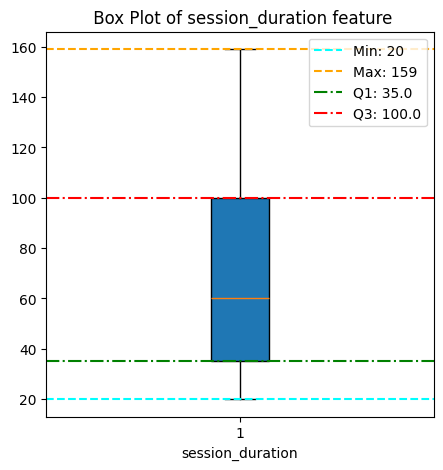

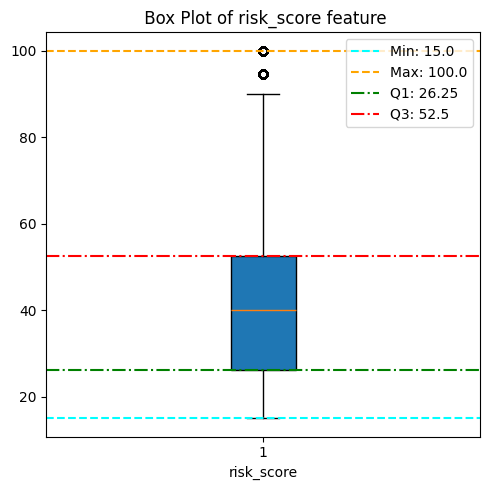

In [14]:
### Visualization of Numerical Features
row_num_number = 3
col_num_number = 2
it = 1

for num_col in numerical_df.columns:
    plt.figure(figsize=(5, 5))
    plt.boxplot(x=numerical_df[num_col], patch_artist=True)
    plt.title(f" Box Plot of {num_col} feature")
    plt.xlabel(num_col)
    # Getting the min and max values for the feature
    min_value = numerical_df[num_col].min()
    max_value = numerical_df[num_col].max()
    
    # Adding horizontal lines for min and max
    plt.axhline(min_value, color=color_list[0], linestyle='--', label=f"Min: {min_value}")
    plt.axhline(max_value, color=color_list[1], linestyle='--', label=f"Max: {max_value}")
    


    # Getting the Q1 and Q3 values for the feature
    q1_value = np.percentile(numerical_df[num_col], 25)
    q3_value = np.percentile(numerical_df[num_col], 75)
    
    # Adding horizontal lines for Q1 and Q3
    plt.axhline(q1_value, color=color_list[2], linestyle='dashdot', label=f"Q1: {q1_value}")
    plt.axhline(q3_value, color=color_list[3], linestyle='dashdot', label=f"Q3: {q3_value}")
    
    # Adding legend for clarity
    plt.legend(loc='upper right')

    it = it + 1

plt.tight_layout()
plt.show()

In [15]:
## Appear some outliers on Q1 and Q3, so we are going to remove them and see the results
## We will use 1.5 times the Q1 and 1.5 times the Q3 and focus on amout of transactions in that range
def remove_outliers(numerical_df):
    for num_col in numerical_df.columns:

        # Calculate Q1, Q3, and IQR
        q1_value = np.percentile(numerical_df[num_col], 25)
        q3_value = np.percentile(numerical_df[num_col], 75)
        iqr = q3_value - q1_value

        # Define the lower and upper bounds for outliers
        lower_bound = q1_value - 1.5 * iqr
        upper_bound = q3_value + 1.5 * iqr

        # Filter out the outliers and replace with NaN
        numerical_df[num_col] = np.where((numerical_df[num_col] < lower_bound) | (numerical_df[num_col] > upper_bound), np.nan, numerical_df[num_col])

    # Optionally, drop or fill NaN values (outliers removed)
    numerical_df = numerical_df.fillna(method='ffill')  # You can replace this with .fillna(method='ffill') or a different imputation method if desired

    return numerical_df


numerical_df = remove_outliers(numerical_df)
numerical_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 78600 entries, 62869 to 52891
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hour_of_day       78600 non-null  float64
 1   amount            78600 non-null  float64
 2   login_frequency   78600 non-null  float64
 3   session_duration  78600 non-null  float64
 4   risk_score        78600 non-null  float64
dtypes: float64(5)
memory usage: 3.6 MB


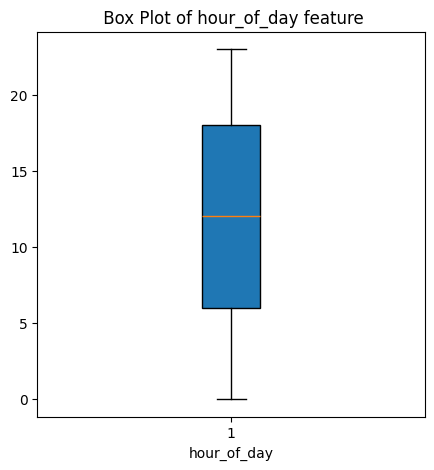

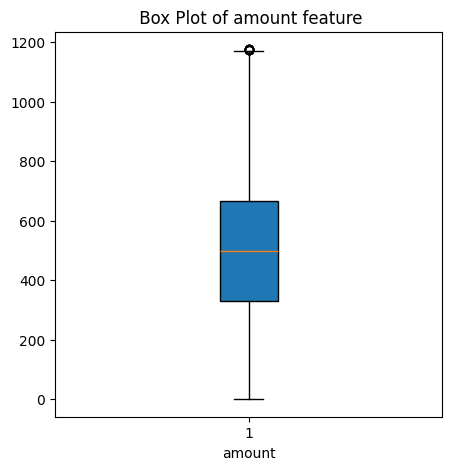

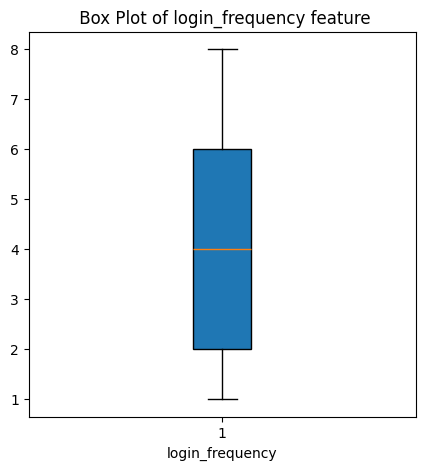

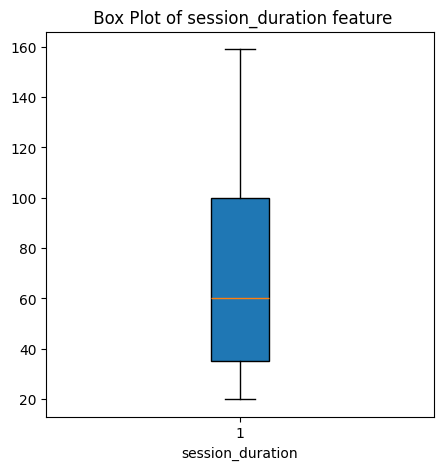

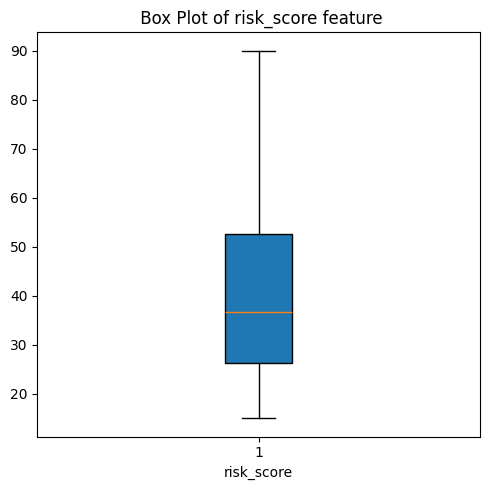

In [16]:
## Checking if there are still outliers
### Visualization of Numerical Features
row_num_number = 3
col_num_number = 2
it = 1

for num_col in numerical_df.columns:
    plt.figure(figsize=(5, 5))
    plt.boxplot(x=numerical_df[num_col], patch_artist=True)
    plt.title(f" Box Plot of {num_col} feature")
    plt.xlabel(num_col)

    it = it + 1

plt.tight_layout()
plt.show()

In [17]:
### Processing for all features
timestamp_df =  data_processed["timestamp"]
data_processed = data_processed.drop(["timestamp"], axis=1)
data_processed

,hour_of_day,amount,transaction_type,location_region,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
62869,0,592.024530,transfer,South America,6,84,high_value,veteran,49.6125,low_risk
41882,0,755.500717,transfer,North America,3,70,focused,established,25.3125,low_risk
31457,0,247.716361,transfer,Asia,5,54,focused,established,20.2500,low_risk
18364,0,422.789709,purchase,North America,4,62,focused,established,35.4375,low_risk
3359,0,353.949174,sale,South America,7,94,high_value,veteran,70.8750,moderate_risk
...,...,...,...,...,...,...,...,...,...,...
28762,23,239.989984,transfer,South America,1,31,random,new,25.0000,low_risk
34614,23,418.844574,transfer,North America,6,139,high_value,veteran,36.7500,low_risk
40329,23,391.235270,transfer,Europe,8,88,high_value,veteran,36.7500,low_risk
62686,23,542.983002,sale,Africa,7,112,high_value,veteran,52.5000,low_risk


In [18]:
data_processed[data_processed["anomaly"] == 2]["risk_score"].max()
# 15 - 59.0625 ==> low_risk  
# 62.5 - 84.375 ==> mederate_risk
# 90 - 100 ==> high_risk

nan

In [19]:
x = data_processed.iloc[:, :-1]
y = data_processed.iloc[:, -1]
x

,hour_of_day,amount,transaction_type,location_region,login_frequency,session_duration,purchase_pattern,age_group,risk_score
62869,0,592.024530,transfer,South America,6,84,high_value,veteran,49.6125
41882,0,755.500717,transfer,North America,3,70,focused,established,25.3125
31457,0,247.716361,transfer,Asia,5,54,focused,established,20.2500
18364,0,422.789709,purchase,North America,4,62,focused,established,35.4375
3359,0,353.949174,sale,South America,7,94,high_value,veteran,70.8750
...,...,...,...,...,...,...,...,...,...
28762,23,239.989984,transfer,South America,1,31,random,new,25.0000
34614,23,418.844574,transfer,North America,6,139,high_value,veteran,36.7500
40329,23,391.235270,transfer,Europe,8,88,high_value,veteran,36.7500
62686,23,542.983002,sale,Africa,7,112,high_value,veteran,52.5000


In [20]:
x_dummies = pd.get_dummies(x, columns=["transaction_type", "location_region", "purchase_pattern","age_group"], drop_first=True, prefix=["transaction_type", "location_region", "purchase_pattern","age_group"], dtype=int)
x_dummies.head()

,hour_of_day,amount,login_frequency,session_duration,risk_score,transaction_type_purchase,transaction_type_sale,transaction_type_scam,transaction_type_transfer,location_region_Asia,location_region_Europe,location_region_North America,location_region_South America,purchase_pattern_high_value,purchase_pattern_random,age_group_new,age_group_veteran
62869,0,592.024530,6,84,49.6125,0,0,0,1,0,0,0,1,1,0,0,1
41882,0,755.500717,3,70,25.3125,0,0,0,1,0,0,1,0,0,0,0,0
31457,0,247.716361,5,54,20.2500,0,0,0,1,1,0,0,0,0,0,0,0
18364,0,422.789709,4,62,35.4375,1,0,0,0,0,0,1,0,0,0,0,0
3359,0,353.949174,7,94,70.8750,0,1,0,0,0,0,0,1,1,0,0,1


<Axes: >

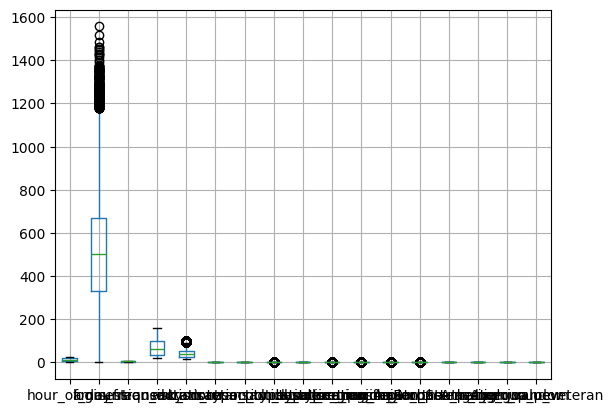

In [21]:
x_dummies.boxplot()

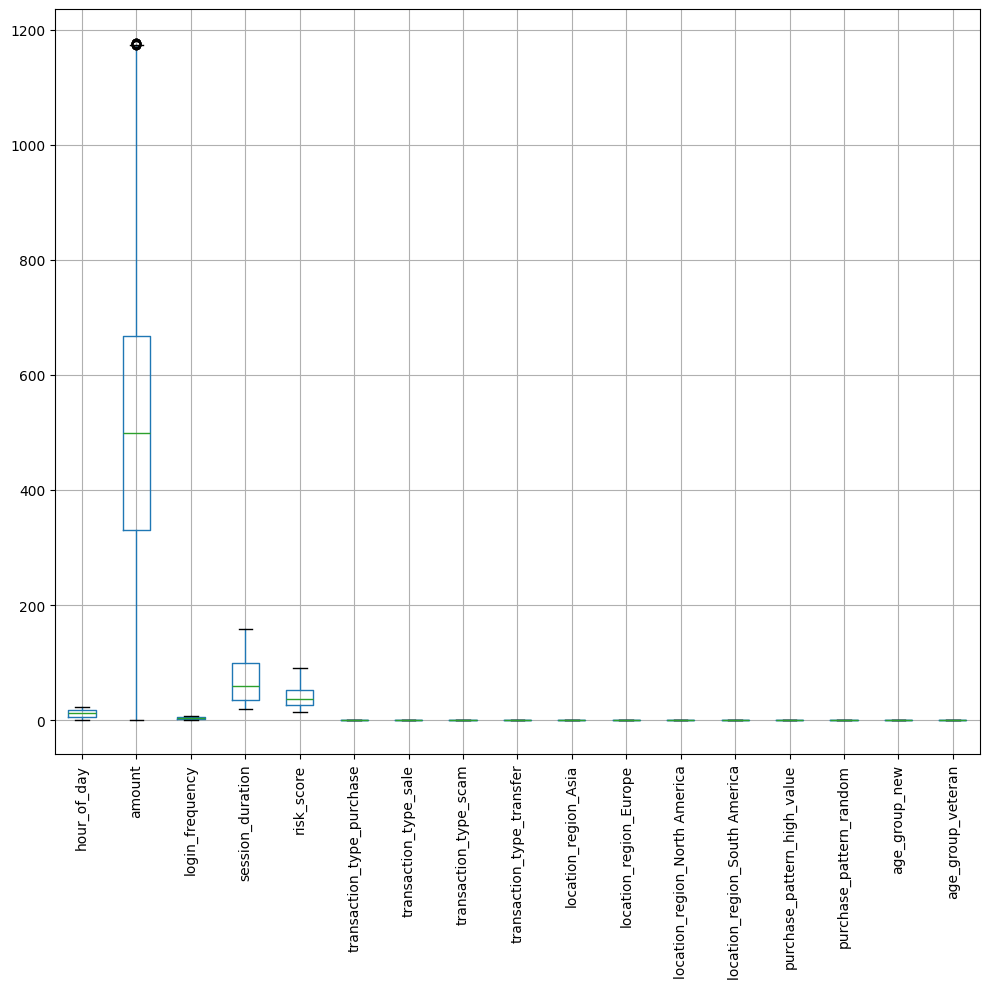

In [22]:
x_dummies = remove_outliers(x_dummies)
plt.figure(figsize=(10, 10))
x_dummies.boxplot()
# Adjust the x-axis tick labels with rotation
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

### Split data and prepare them for training models 

In [23]:
y

62869         low_risk
41882         low_risk
31457         low_risk
18364         low_risk
3359     moderate_risk
             ...      
28762         low_risk
34614         low_risk
40329         low_risk
62686         low_risk
52891    moderate_risk
Name: anomaly, Length: 78600, dtype: object

In [24]:
print(y.unique())
# I will convert  low_risk to 0, moderate_risk to 1, high_risk to 2 
y.replace({'low_risk': 0, 'moderate_risk' : 1, 'high_risk' : 2 }, inplace=True)
y

['low_risk' 'moderate_risk' 'high_risk']


62869    0
41882    0
31457    0
18364    0
3359     1
        ..
28762    0
34614    0
40329    0
62686    0
52891    1
Name: anomaly, Length: 78600, dtype: int64

In [25]:
# Normalization
scaler = MinMaxScaler()
x_dummies_scaled = scaler.fit_transform(x_dummies)
x_dummies_df = pd.DataFrame(x_dummies_scaled, columns=x_dummies.columns)
x_dummies_df.head()

,hour_of_day,amount,login_frequency,session_duration,risk_score,transaction_type_purchase,transaction_type_sale,transaction_type_scam,transaction_type_transfer,location_region_Asia,location_region_Europe,location_region_North America,location_region_South America,purchase_pattern_high_value,purchase_pattern_random,age_group_new,age_group_veteran
0,0.0,0.503082,0.714286,0.460432,0.4615,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,1.0
1,0.0,0.642001,0.285714,0.359712,0.1375,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.210496,0.571429,0.244604,0.0700,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.359270,0.428571,0.302158,0.2725,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.300770,0.857143,0.532374,0.7450,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [26]:
x_dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78600 entries, 0 to 78599
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hour_of_day                    78600 non-null  float64
 1   amount                         78600 non-null  float64
 2   login_frequency                78600 non-null  float64
 3   session_duration               78600 non-null  float64
 4   risk_score                     78600 non-null  float64
 5   transaction_type_purchase      78600 non-null  float64
 6   transaction_type_sale          78600 non-null  float64
 7   transaction_type_scam          78600 non-null  float64
 8   transaction_type_transfer      78600 non-null  float64
 9   location_region_Asia           78600 non-null  float64
 10  location_region_Europe         78600 non-null  float64
 11  location_region_North America  78600 non-null  float64
 12  location_region_South America  78599 non-null 

In [27]:
## Handling Missing Values
x_dummies_df.isnull().sum()

hour_of_day                      0
amount                           0
login_frequency                  0
session_duration                 0
risk_score                       0
transaction_type_purchase        0
transaction_type_sale            0
transaction_type_scam            0
transaction_type_transfer        0
location_region_Asia             0
location_region_Europe           0
location_region_North America    0
location_region_South America    1
purchase_pattern_high_value      0
purchase_pattern_random          0
age_group_new                    0
age_group_veteran                0
dtype: int64

In [28]:
def fill_missing_values(df):
    df.fillna(df.mean(), inplace=True)
    return df

x_dummies_df = fill_missing_values(x_dummies_df)
x_dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78600 entries, 0 to 78599
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hour_of_day                    78600 non-null  float64
 1   amount                         78600 non-null  float64
 2   login_frequency                78600 non-null  float64
 3   session_duration               78600 non-null  float64
 4   risk_score                     78600 non-null  float64
 5   transaction_type_purchase      78600 non-null  float64
 6   transaction_type_sale          78600 non-null  float64
 7   transaction_type_scam          78600 non-null  float64
 8   transaction_type_transfer      78600 non-null  float64
 9   location_region_Asia           78600 non-null  float64
 10  location_region_Europe         78600 non-null  float64
 11  location_region_North America  78600 non-null  float64
 12  location_region_South America  78600 non-null 

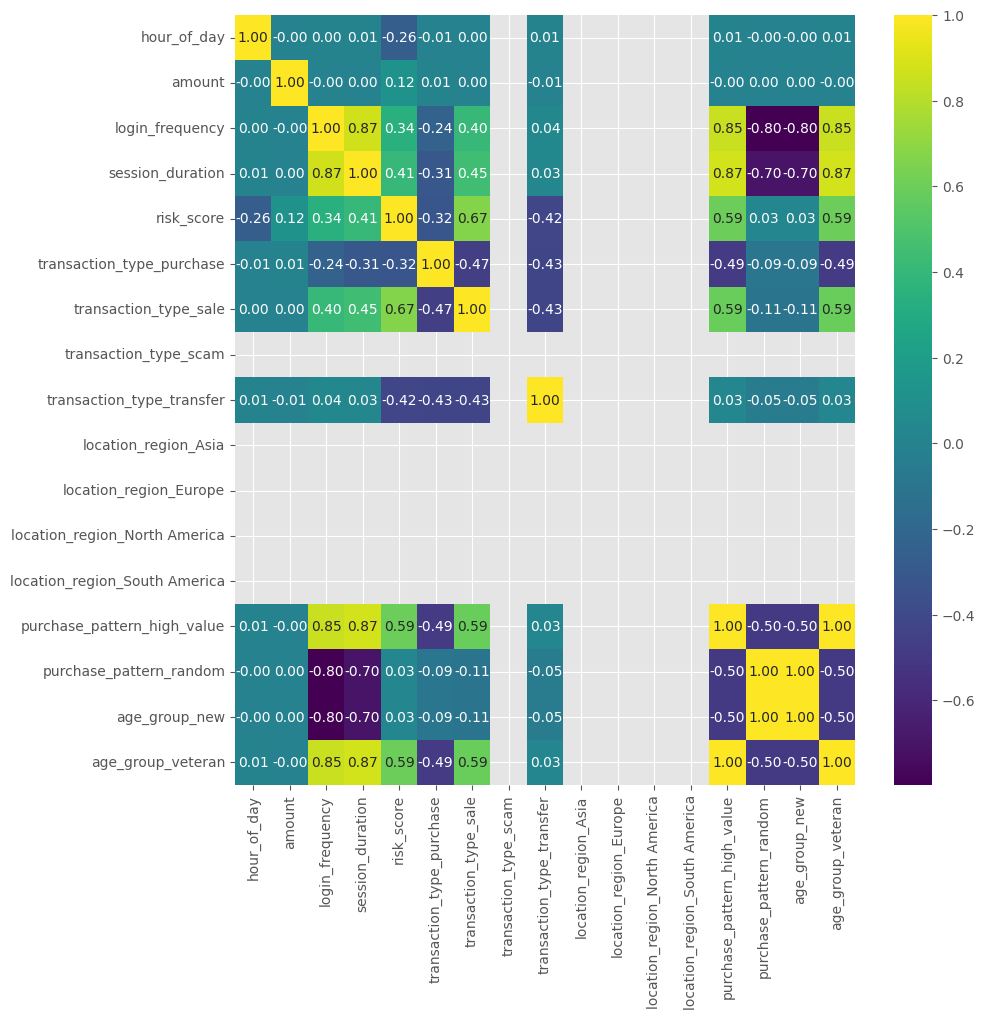

In [29]:
plt.style.use('ggplot')
plt.subplots(figsize=(10, 10))
sns.heatmap(x_dummies_df.corr(),annot=True, fmt='.2f', cmap='viridis' )
plt.show()

In [30]:
### the correlation between purchase_pattern_random and parchase_pattern_high_value have a completely similar correlation of age_group_new and age_group_veteran.

# We will remove the correlation between purchase_pattern_random and parchase_pattern_high_value

x_dummies_df.drop(["purchase_pattern_high_value", "purchase_pattern_random"], axis=1, inplace=True)

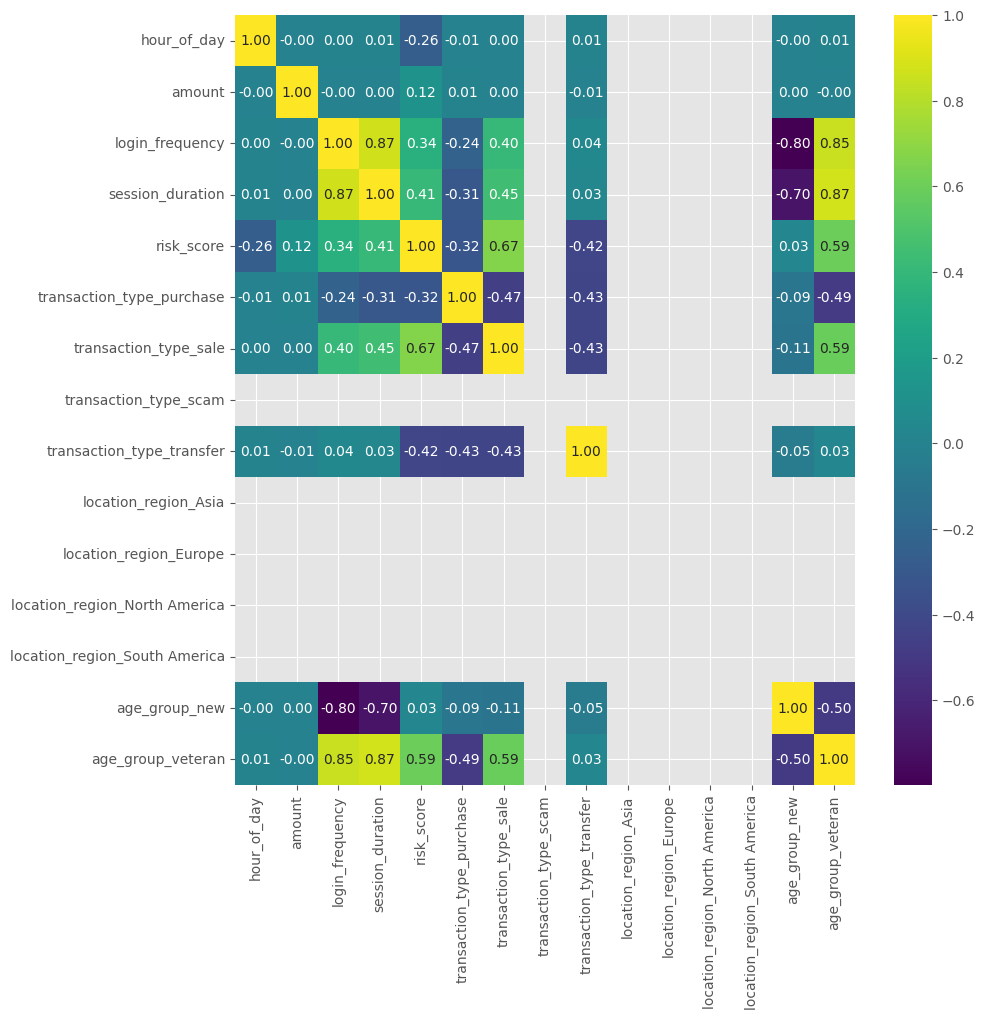

In [31]:
# Review again the correlation matrix
plt.style.use('ggplot')
plt.subplots(figsize=(10, 10))
sns.heatmap(x_dummies_df.corr(),annot=True, fmt='.2f', cmap='viridis' )
plt.show()

In [32]:
### Splitting the dataset into the Training set, Validation and Test set

RANDOM_SEED = 2024
TEST_SIZE = 0.2 
VAL_SIZE = 0.15
X_train, X_test, y_train, y_test = train_test_split(x_dummies_df, y, test_size = TEST_SIZE, random_state = RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = VAL_SIZE, random_state = RANDOM_SEED)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (53448, 15)
y_train shape: (53448,)
X_val shape: (9432, 15)
y_val shape: (9432,)
X_test shape: (15720, 15)
y_test shape: (15720,)


#### MOdels

#### RandomForest Model

In [33]:
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 2024
rfc_model = RandomForestClassifier(random_state=RANDOM_STATE, 
                                   n_estimators=100, 
                                   criterion="entropy", 
                                   max_depth=10, 
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   min_weight_fraction_leaf=0.0,
                                   max_features=1.0)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=1.0,
                       random_state=2024)

In [34]:
from sklearn.metrics import classification_report
y_pred_rfc = rfc_model.predict(X_test)
print(classification_report(y_test, y_pred_rfc))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12778
           1       1.00      1.00      1.00      1683
           2       1.00      1.00      1.00      1259

    accuracy                           1.00     15720
   macro avg       1.00      1.00      1.00     15720
weighted avg       1.00      1.00      1.00     15720



In [35]:
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score,
    roc_curve, 
    auc, 
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize

def auc_roc_curve(fpr, tpr, roc_auc, n_classes):
    # ROC Curve
    plt.subplot(2, 1, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.5])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

def auc_pr_curve(precision, recall, pr_auc, n_classes):
    # Precision-Recall Curve
    plt.subplot(2, 1, 2)
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {pr_auc[i]:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.5])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

def get_score(y_true, y_pred, y_scores, n_classes):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Convert y_test to binary format

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute Precision-Recall curve and AUC for each class
    precision_curve_pr = {}
    recall_curve_pr = {}
    pr_auc = {}
    for i in range(n_classes):
        precision_curve_pr[i], recall_curve_pr[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
        pr_auc[i] = auc(recall_curve_pr[i], precision_curve_pr[i])


    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1-score: {f1:.2f}")

    auc_roc_curve(fpr, tpr, roc_auc, n_classes)
    auc_pr_curve(precision_curve_pr, recall_curve_pr, pr_auc, n_classes)
    print("Complete!")

    return accuracy, recall, precision, f1

Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1-score: 1.00


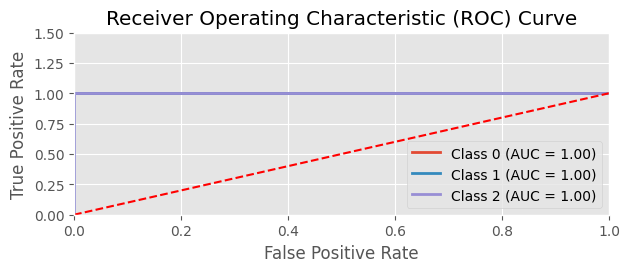

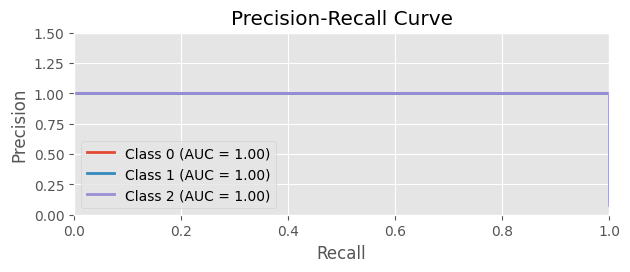

Complete!


(1.0, 1.0, 1.0, 1.0)

In [36]:
y_score = rfc_model.predict_proba(X_test)
get_score(y_test, y_pred_rfc, y_score, 3)

### Gradient Boosting Model

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(random_state=RANDOM_STATE,
                                       n_estimators=100,
                                       learning_rate=0.1,
                                       max_depth=10,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf=0.0,
                                       max_features=1.0)
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, max_features=1.0, random_state=2024)

In [38]:
from sklearn.metrics import classification_report
y_pred_gbc = gbc_model.predict(X_test)
print(classification_report(y_test, y_pred_gbc))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12778
           1       1.00      1.00      1.00      1683
           2       1.00      1.00      1.00      1259

    accuracy                           1.00     15720
   macro avg       1.00      1.00      1.00     15720
weighted avg       1.00      1.00      1.00     15720



Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1-score: 1.00


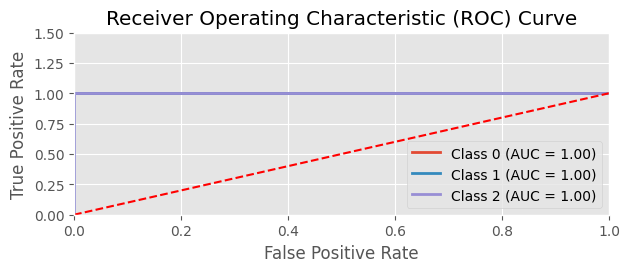

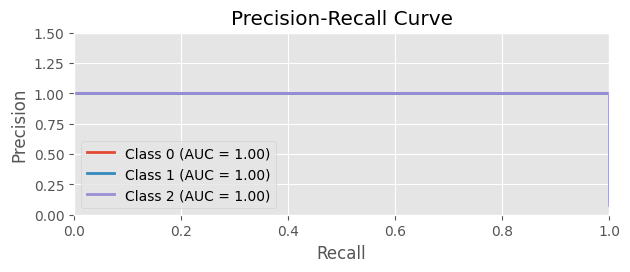

Complete!


(1.0, 1.0, 1.0, 1.0)

In [39]:
y_score_gbc = gbc_model.predict_proba(X_test)
get_score(y_test, y_pred_gbc, y_score_gbc, 3)

### Logistic Regression Models

In [40]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=RANDOM_STATE,
                              max_iter=1000,
                              solver='lbfgs',
                              multi_class='multinomial')
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=2024)

In [41]:
from sklearn.metrics import classification_report
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12778
           1       1.00      1.00      1.00      1683
           2       1.00      1.00      1.00      1259

    accuracy                           1.00     15720
   macro avg       1.00      1.00      1.00     15720
weighted avg       1.00      1.00      1.00     15720



Accuracy: 1.00
Recall: 1.00
Precision: 1.00
F1-score: 1.00


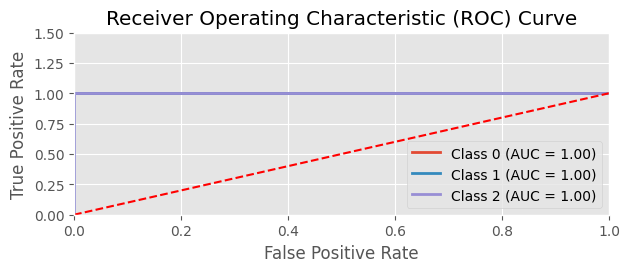

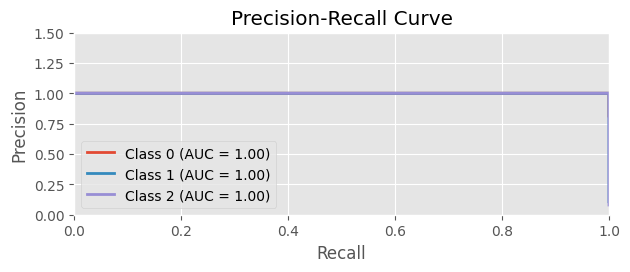

Complete!


(0.9999363867684479,
 0.9999363867684479,
 0.9999363917463985,
 0.9999363785607953)

In [42]:
y_score_lr = lr_model.predict_proba(X_test)
get_score(y_test, y_pred_lr, y_score_lr, 3)

#### Preparation Dataset for Deep Learning Models

In [43]:
### Preparation for training the model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")
print(f"X_val shape: {X_val_tensor.shape}")
print(f"y_val shape: {y_val_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"y_test shape: {y_test_tensor.shape}")


X_train shape: torch.Size([53448, 15])
y_train shape: torch.Size([53448])
X_val shape: torch.Size([9432, 15])
y_val shape: torch.Size([9432])
X_test shape: torch.Size([15720, 15])
y_test shape: torch.Size([15720])


In [44]:
from torch.utils.data import Dataset

class AnodDectionDataset(Dataset):
    def __init__(self, X, y):
        super(AnodDectionDataset, self).__init__()

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset_tensor = AnodDectionDataset(X_train_tensor, y_train_tensor)
val_dataset_tensor = AnodDectionDataset(X_val_tensor, y_val_tensor)
test_dataset_tensor = AnodDectionDataset(X_test_tensor, y_test_tensor)



In [45]:
# Create DataLoader for each dataset
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_tensor, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_tensor, batch_size=batch_size, shuffle=False)


###  LSTM-CNN Hybrid Models

In [46]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 num_layers: int, 
                 num_classes: int,
                 dropout_prob: float, 
                 kernel_size: int,
                 padding_size: int,
                 stride_size: int,  
                 eps: float, # 1e-05
                 momentum: float, # 0.1
                 offine: bool, # True
                 track_running_stats: bool, # True
                 device: str = 'cpu'):
        
        super(LSTM_CNN_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=kernel_size, padding=padding_size)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=padding_size)
        self.conv3 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=padding_size)
        # self.fc = nn.Linear(hidden_size, num_classes)
        self.max_pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride_size, padding=padding_size)
        # self.timed = nn.TimeDistributed(self.fc)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.batch_norm = nn.BatchNorm1d(hidden_size, 
                                         eps=eps, 
                                         momentum=momentum, 
                                         affine=offine, 
                                         track_running_stats=track_running_stats
                                         )
        self.sigmoid = nn.Sigmoid()

        self.device = device

    def forward(self, x):
        """


        Args:
            x (torch.Tensor): input tensor of shape (n_samples, channels, n_features)

        Returns:    

            
        """
        # Set initial hidden and cell states
        hidden, cell = self.init_hidden(x.shape[0])
        # print(f"Hiden: {hidden.shape}") # (2, 32, 64)
        # print(f"Cell: {cell.shape}") # (2, 32, 64)


        # Apply CNN layers 
        out = self.CnnBlock(x) # (32, 4096)
        ## Platten 
        out = self.flatten(out) # (32, 4096)

        out = self.dropout(out) # (32, 4096)
        out = out.view(out.shape[0], self.lstm.hidden_size, self.lstm.hidden_size) # (32, 64, 64)

        # Forward propagate LSTM
        out = self.LstmBlock(out, hidden, cell)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        

        return out
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(self.device)
        c = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(self.device)
        return h, c
    
    def predict(self, x):
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            h0 = torch.zeros(self.lstm.num_layers, self.input_size, self.lstm.hidden_size).to(self.device)
            c0 = torch.zeros(self.lstm.num_layers, self.input_size, self.lstm.hidden_size).to(self.device)
            out, _ = self.lstm(x, (h0, c0))
            out = out.reshape(out.shape[0], -1)
            out = self.relu(self.conv1(out))
            out = self.relu(self.conv2(out))
            out = self.fc(out)
            out = torch.sigmoid(out)
            return out
    
    def LstmBlock(self, x, hidden, cell):
        # Forward propagate LSTM
        out, _ = self.lstm(x, (hidden, cell))

        # Reshape output to (batch_size*seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)  # (32, 4096)
        # print(out.shape)
        
        # Apply fully connected layer
        out = self.FullyConnectedBlock(out, hidden_size=out.shape[1], num_classes=out.shape[1]*2) # out: tensor of shape (batch_size, hidden_size)
        out = self.FullyConnectedBlock(out, hidden_size=out.shape[1], num_classes=self.num_classes) # out: tensor of shape (batch_size, num_classes)
        out = self.sigmoid(out)
        return out

    def CnnBlock(self, x):
        """

        Args:
            x (torch.Tensor): input tensor of shape (n_samples, channels, n_features)

        Returns:

        """
        # Apply convolution layers 
        out = self.relu(self.conv1(x)) # out: tensor of shape (batch_size, channels, hidden_size)
        out = self.batch_norm(out) # out: tensor of shape (batch_size, channels, hidden_size)
        out = self.relu(self.conv2(out))
        out = self.batch_norm(out)
        out = self.relu(self.conv3(out))
        out = self.batch_norm(out)

        # Apply max pooling
        out = self.max_pool(out)

        out = self.dropout(out) # out: tensor of shape (batch_size, channels, n_features)

        out = out.reshape(out.shape[0], -1) # out: tensor of shape (batch_size, channels*n_features)
        # Apply fully connected layer
        out = self.FullyConnectedBlock(out, hidden_size=out.shape[1], num_classes=out.shape[1] * 2) # out: tensor of shape (batch_size, channels*n_features * 2)
        out = self.FullyConnectedBlock(out, hidden_size=out.shape[1], num_classes=out.shape[1]) # out: tensor of shape (batch_size, channels*n_features)
        out = self.FullyConnectedBlock(out, hidden_size=out.shape[1], num_classes=self.hidden_size*self.hidden_size) # out: tensor of shape (batch_size, hidden_size)
        # out = self.FullyConnectedBlock(out, hidden_size=out.shape[1], num_classes=self.hidden_size) # out: tensor of shape (batch_size, hidden_size)
        
        # print(out.shape)
        return out
    
    def FullyConnectedBlock(self, x, hidden_size=64, num_classes=1):
        self.fc = nn.Linear(hidden_size, num_classes)
        out = self.fc(x)
        return out
    

    


In [47]:
input_size = 1
hidden_size = 64
num_layers = 2
num_classes = len(y_train.unique())
dropout_prob = 0.2
kernel_size = 3
padding_size = 1
stride_size = 1
eps = 1e-05
momentum = 0.1
offine = True
track_running_stats = True
device = 'cpu'


In [48]:
X_train.shape

(53448, 15)

In [49]:

cnn_lstm_model = LSTM_CNN_Model(input_size=input_size, 
                                hidden_size=hidden_size, 
                                num_layers=num_layers,
                                num_classes=num_classes,
                                dropout_prob=dropout_prob,
                                kernel_size=kernel_size,
                                padding_size=padding_size,
                                stride_size=stride_size,
                                eps=eps,
                                momentum=momentum,
                                offine=offine,
                                track_running_stats=track_running_stats,
                                device=device
                                )
cnn_lstm_model

LSTM_CNN_Model(
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)

In [50]:
def train_model(model, train_loader, optimizer, loss_function, num_epoch):
    model.train(True)
    print(f"Training model for {num_epoch} epochs")
    loss_train = 0.0

    for batch_index, batch in enumerate(train_loader):
        data = batch[0].to(device)
        labels = batch[1].to(device).type(torch.long)

        # convert shape from (batch_size, n_features) to (batch_size, in_channels, n_features)
        data = data.reshape(data.shape[0], 1, data.shape[1])
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        # print(outputs.requires_grad)  # Should be True
        # print(labels.requires_grad)  # Should be False, as it's not a parameter
        # logits = torch.argmax(outputs, dim=1).type(torch.float32)
        loss = loss_function(outputs, labels)
        loss_train += loss.item()
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if (batch_index) % 100 == 99: # Print every 100 mini-batches
            avg_loss_train = loss_train / 100
            print ('Step/Batch [{}/{}], Loss: {:.4f}'
                   .format(batch_index+1, len(train_loader), avg_loss_train))
            loss_train = 0.0

    print("****"*10)
    print()

In [51]:
def validation_model(model, val_loader, loss_function, num_epoch):
    model.eval()
    model.train(False)
    print(f"Validating model for {num_epoch} epochs")
    los_val = 0.0

    for batch_index, batch in enumerate(val_loader):
        data = batch[0].to(device)
        labels = batch[1].to(device).type(torch.long)

        # convert shape from (batch_size, n_features) to (batch_size, in_channels, n_features)
        data = data.reshape(data.shape[0], 1, data.shape[1])
        
        with torch.no_grad():
            # Forward pass
            outputs = model(data)
            loss = loss_function(outputs, labels)
            los_val += loss.item()
        
    avg_loss_val = los_val / len(val_loader)
    print ('Loss: {:.4f}'
           .format(avg_loss_val))
    print("****"*10)
    print()

def test_model(model, test_loader, loss_function):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_index, batch in enumerate(test_loader):
        data = batch[0].to(device)
        labels = batch[1].to(device).type(torch.long)

        # Reshape data if needed (e.g., for CNN+LSTM input format)
        data = data.reshape(data.shape[0], 1, data.shape[1])
        
        with torch.no_grad():
            outputs = model(data)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

            # Assuming binary or multi-class classification
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples * 100

    print("Testing Results: ")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print("****" * 10)

In [52]:
# learning_rate = 1e-3

# optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)
# num_epochs = 10
# loss_function = nn.CrossEntropyLoss()

# for epoch in range(num_epochs):
#     train_model(cnn_lstm_model, train_loader, optimizer, loss_function, epoch)
#     validation_model(cnn_lstm_model, val_loader, loss_function, epoch)
    
   
    

In [53]:
# test_model(cnn_lstm_model, test_loader, loss_function)


In [54]:
# def plot_history(history):
#     plt.plot(history.history['loss'], label='loss')
#     plt.plot(history.history['val_loss'], label='val_loss')
#     plt.title('History Loss Curve')
#     plt.xlabel('Epoch')
#     plt.ylabel('loss')
#     plt.legend()
#     plt.show()


# plot_history(history)

### TAnoGAN: Time Series Anomaly Detection with Generative Adversarial Networks

https://github.com/mdabashar/TAnoGAN/blob/master/models/recurrent_models_pyramid.py

In [55]:
import torch.nn as nn

class LSTMGenerator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.

    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms

    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """

    def __init__(self, in_dim, out_dim, device=None):
        super().__init__()
        self.out_dim = out_dim
        self.device = device

        self.lstm0 = nn.LSTM(in_dim, hidden_size=32, num_layers=1, batch_first=True)
        self.lstm1 = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)
        
        # self.linear = nn.Sequential(nn.Linear(in_features=128, out_features=out_dim), nn.Tanh())
        self.linear = nn.Sequential(nn.Linear(in_features=128, out_features=out_dim), nn.Softmax(dim = -1))

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(1, batch_size, 32).to(self.device)
        c_0 = torch.zeros(1, batch_size, 32).to(self.device)

        recurrent_features, (h_1, c_1) = self.lstm0(input, (h_0, c_0))
        recurrent_features, (h_2, c_2) = self.lstm1(recurrent_features)
        recurrent_features, _ = self.lstm2(recurrent_features)
        
        outputs = self.linear(recurrent_features.contiguous().view(batch_size*seq_len, 128))
        outputs = outputs.view(batch_size, seq_len, self.out_dim)
        return outputs, recurrent_features


class LSTMDiscriminator(nn.Module):
    """An LSTM based discriminator. It expects a sequence as input and outputs a probability for each element. 

    Args:
        in_dim: Input noise dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms

    Inputs: sequence of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, 1)
    """

    def __init__(self, in_dim, device=None):
        super().__init__()
        self.device = device

        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Sequential(nn.Linear(100, 3), nn.Sigmoid())

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(1, batch_size, 100).to(self.device)
        c_0 = torch.zeros(1, batch_size, 100).to(self.device)

        recurrent_features, _ = self.lstm(input, (h_0, c_0))
        outputs = self.linear(recurrent_features.contiguous().view(batch_size*seq_len, 100))
        outputs = outputs.view(batch_size, seq_len, 3)
        return outputs, recurrent_features


class TAnoGAN(nn.Module):
    def __init__(self, gen_in_dim, gen_out_dim, dis_in_dim, device=None):
        super(TAnoGAN, self).__init__()
        self.device = device

        # Initialize the generator and discriminator
        self.generator = LSTMGenerator(gen_in_dim, gen_out_dim, device=self.device)
        self.discriminator = LSTMDiscriminator(dis_in_dim, device=self.device)

    def forward(self, noise, types=None):
        generated_out, gen_features, dis_output, dis_features = [None for _ in range(4)]
        if types == "all":
            # Generate synthetic data from the noise
            generated_out, gen_features = self.generator(noise)

            # Use the discriminator to evaluate the generated data
            dis_output, dis_features = self.discriminator(generated_out)

        elif types == "gen":
            generated_out, gen_features = self.generator(noise)
        elif types == "dis":
            dis_output, dis_features = self.discriminator(noise)

        return generated_out, dis_output, gen_features, dis_features


In [56]:
# seq_len (Sequence Length): This represents the length of each time series sequence in the batch. For example, if you are working with a time series of 32 time steps, then seq_len would be 32.

# in_dim (Input Dimension): This is the number of features in each time step of the sequence. For instance, if each time step in your series has 4 features, then in_dim would be 4.

In [57]:
def get_labels(data):
    # Ensure the input is a 1D tensor
    if data.dim() == 2 and data.size(1) == 1:
        data = data.squeeze()  # Convert from (N, 1) to (N,)

    # Define normalization parameters
    min_val = 15.0
    max_val = 100.0

    # Normalize data to the range [0, 100]
    normalized_data = (data - min_val) / (max_val - min_val) * 100

    # Define thresholds for labeling
    low_risk_threshold = 60
    moderate_risk_threshold = 85
    high_risk_threshold = 100.0

    # Initialize labels tensor
    labels = torch.zeros_like(normalized_data, dtype=torch.long)

    # Apply thresholds for labeling
    labels[normalized_data < low_risk_threshold] = 0    # Low risk
    labels[(normalized_data >= low_risk_threshold) & (normalized_data < moderate_risk_threshold)] = 1  # Moderate risk
    labels[normalized_data >= moderate_risk_threshold] = 2  # High risk

    return  labels.unsqueeze(1).type(torch.float32)

In [102]:
def train(model, train_loader, criterion, gen_optimizer, dis_optimizer, in_dim, num_epoch, device):
    model.train()  # Set model to training mode
    print(f"Training for {num_epoch} epochs")
    gen_losses, dis_losses = [], []

    for real_data, labels in train_loader:  # Assuming labels are provided for each sequence
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train Discriminator
        dis_optimizer.zero_grad()

        real_data = real_data.to(device)
        labels = labels.to(device)

        # convert data to tensor with shape (batch_size, seq_len, in_dim) = (32, 100, 15)
        seq_len = 100
        padding_len = seq_len - 1  # Adding 99 zeros to each sequence

        # Repeat and pad
        real_data_expanded = real_data.unsqueeze(1).repeat(1, padding_len, 1)
        real_data = torch.cat((real_data.unsqueeze(1), real_data_expanded), dim=1)

        batch_size, seq_len, _ = real_data.size() # batch_size, seq_len=n_features

        # Generate fake data
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).to(device)
        # print(noise.shape)
        fake_data, _, _, _ = model(noise, types="gen")

        # Discriminator loss on real data
        _, real_output, _, _ = model(real_data, types="dis")
        labels = labels.type(torch.long) # Flatten labels for Cross-Entropy
        # print(labels.shape) # (batch_size, 1)
        # print(real_output.shape) # (batch_size, seq_len, 1)  = (128, 100, 1)
        
        # Take the mean across the second dimension
        real_output = real_output.mean(dim=1)  # This will average the 100 values (128, 3) (beucause of 3 classes)
        dis_real_loss = criterion(real_output, labels)

        # Discriminator loss on fake data (label as one of the classes, e.g., "2" for fake)
        _, fake_output, _, _ = model(fake_data.detach(), types="dis")
        fake_labels = torch.full((batch_size, 3), 3, dtype=torch.long).to(device)  # Label as class 2
        dis_fake_loss = criterion(fake_output, fake_labels)

        dis_loss = dis_real_loss + dis_fake_loss
        dis_loss.backward()
        dis_optimizer.step()
        dis_losses.append(dis_loss.item())

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        # Train Generator
        gen_optimizer.zero_grad()

        # Generator loss (aiming to match the real class distributions)
        _, fake_output, _, _ = model(fake_data, types="dis")
        fake_output = fake_output.mean(dim=1)
        gen_loss = criterion(fake_output, labels)  # Use the real labels for fooling
        gen_loss.backward()
        gen_optimizer.step()
        gen_losses.append(gen_loss.item())

    return gen_losses, dis_losses

In [103]:
def validate(model, val_loader, criterion, num_epoch, device):
    model.eval()  # Set model to evaluation mode
    print(f"Validating model for {num_epoch} epochs...")
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)

            # convert data to tensor with shape (batch_size, seq_len, in_dim) = (32, 100, 15)
            seq_len = 100
            padding_len = seq_len - 1  # Adding 99 zeros to each sequence

            # Repeat and pad
            data_expanded = data.unsqueeze(1).repeat(1, padding_len, 1)
            data = torch.cat((data.unsqueeze(1), data_expanded), dim=1)

            batch_size, seq_len, _ = data.size() # batch_size, seq_len=n_features

            # Discriminator's output
            _, outputs, _, _ = model(data, types="dis")
            outputs = outputs.mean(dim=1)  # Flatten for CrossEntropy
            labels = labels.view(-1).type(torch.long)   # Flatten labels
            
            # print(outputs.shape)
            # print(labels.shape)
            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)


    # Average loss and accuracy
    val_loss /= len(val_loader)
    accuracy = correct / total * 100

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')
    return val_loss, accuracy

In [104]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(model, x, G_z, Lambda=0.1):
    # print(x)
    # print(x.shape) # (128, 100, 15)
    # print(G_z)
    # print(G_z.shape) # (128, 100, 15)
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    _, output_real, _,  x_feature =  model(x.to(device), types="dis") 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    _, output_fake, _, G_z_feature = model(G_z.to(device), types="dis") 

    # print(x_feature)
    # print(x_feature.shape)
    # print(G_z_feature)
    # print(G_z_feature.shape)
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss, output_real, output_fake

In [132]:
# def test_model(model, test_loader, device):
#     model.eval()  # Set model to evaluation mode
#     all_preds, all_labels = [], []

#     with torch.no_grad():
#         for data, labels in test_loader:
#             data, labels = data.to(device), labels.to(device)
            
#             # Discriminator output probabilities
#             output, _ = model.discriminator(data)
#             pred_classes = torch.argmax(output, dim=-1)
            
#             all_preds.extend(pred_classes.view(-1).cpu().numpy())
#             all_labels.extend(labels.view(-1).cpu().numpy())

#     # Now `all_preds` and `all_labels` contain the predicted and true class labels, respectively.
#     # You can calculate accuracy or any other metric here.
#     accuracy = accuracy_score(all_labels, all_preds)
#     print(f'Test Accuracy: {accuracy:.2f}%')
    
def test_model(model, test_loader, par_test, device):
    """
    model: the model to be tested
    test_loader: test data loader
    par_test:   parameters of the test data (batch_size, window_length, n_feature)
    device: cuda or cpu
    """
    model.eval()  # Set model to evaluation mode
    loss_list = []
    correct_real, correct_fake = 0, 0
    total = 0
    #y_list = []
    for i, (real_data,labels) in enumerate(test_loader):
        # print(i, y)
        # convert data to tensor with shape (batch_size, seq_len, in_dim) = (32, 100, 15)
        seq_len = 100
        padding_len = seq_len - 1  # Adding 99 zeros to each sequence

        # Repeat and pad
        data_expanded = real_data.unsqueeze(1).repeat(1, padding_len, 1)
        real_data = torch.cat((real_data.unsqueeze(1), data_expanded), dim=1)
        
        # z is fake data 
        # Generate fake data
        noise = Variable(init.normal(torch.zeros(real_data.size(0), 
                                        par_test["n_feature"],
                                        par_test["window_length"]),mean=0,std=0.1),requires_grad=True)
        


        #z = x
        # print(f"Noise Shape: {noise.shape}")
        z_optimizer = torch.optim.Adam([noise],lr=1e-2)
        
        # real data
        # print()
        loss = None
        for j in range(50): # set your interation range
            gen_fake,_, _, _ = model(noise.to(device), types="gen")
            # print(f"gen_fake: {gen_fake.shape}")
            # print(f"real_data: {Variable(real_data).to(device).shape}")
            loss, out_real, out_fake = Anomaly_score(model, Variable(real_data).to(device), gen_fake)
            loss.backward()
            z_optimizer.step()

        loss_list.append(loss) # Store the loss from the final iteration
        #y_list.append(y) # Store the corresponding anomaly label
            #         total_correct += (predicted == labels).sum().item()
            # total_samples += labels.size(0)
        # print(out_real.shape, out_fake.shape)
        # noise.mean(dim=1).argmax(dim=1)
        out_real_data = out_real.mean(dim=1).argmax(dim=1)
        out_fake_data = out_fake.mean(dim=1).argmax(dim=1)
        # print(out_real_data.shape, out_fake_data.shape)
        
        correct_real += (out_real_data == labels).sum().item()
        correct_fake +=(out_fake_data == labels).sum().item()
        total += len(real_data)

        print('~~~~~~~~ Loss = {}'.format(loss))
        
    return torch.mean(torch.tensor(loss_list)), correct_real*100 / total, correct_fake*100 / total

In [106]:
# Define hyperparameters
num_epochs = 10
batch_size = 128
noise_dim = 100
seq_dim = 15
learning_rate = 2e-4
in_dim: int = 100
out_dim: int = 100


In [107]:
# #  Define the discriminator LSTM model
# discriminator_tgans_model = LSTMDiscriminator(
#     in_dim=100, 
#     device=device
# )
# discriminator_tgans_model = discriminator_tgans_model.to(device)

# # Define the generator LSTM model
# generator_tgans_model = LSTMGenerator(
#     in_dim=100, 
#     out_dim=out_dim, 
#     device=device
# )
# generator_tgans_model = generator_tgans_model.to(device)

gen_in_dim: int = in_dim 
gen_out_dim: int = seq_dim
dis_in_dim: int = seq_dim

# Define the TGANS model
tgans_model = TAnoGAN(
    gen_in_dim=gen_in_dim, 
    gen_out_dim=gen_out_dim, 
    dis_in_dim=dis_in_dim,
    device=device
)

tgans_model = tgans_model.to(device)

tgans_model


TAnoGAN(
  (generator): LSTMGenerator(
    (lstm0): LSTM(100, 32, batch_first=True)
    (lstm1): LSTM(32, 64, batch_first=True)
    (lstm2): LSTM(64, 128, batch_first=True)
    (linear): Sequential(
      (0): Linear(in_features=128, out_features=15, bias=True)
      (1): Softmax(dim=-1)
    )
  )
  (discriminator): LSTMDiscriminator(
    (lstm): LSTM(15, 100, batch_first=True)
    (linear): Sequential(
      (0): Linear(in_features=100, out_features=3, bias=True)
      (1): Sigmoid()
    )
  )
)

In [108]:
# Define Cross-Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define Adam optimizer
gen_optimizer = torch.optim.Adam(tgans_model.generator.parameters(), lr=learning_rate)
dis_optimizer = torch.optim.Adam(tgans_model.discriminator.parameters(), lr=learning_rate)

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    epoch_nums.append(epoch)

    # Train
    gen_losses, dis_losses = train(tgans_model, train_loader, criterion, gen_optimizer, dis_optimizer, noise_dim, epoch, device=device)
    
    # Save losses
    training_loss.append((gen_losses, dis_losses))
    # Print losses for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Gen Loss: {torch.mean(torch.tensor(gen_losses)):.4f}, "
          f"Dis Loss: {torch.mean(torch.tensor(dis_losses)):.4f}")
    
    # Validation
    val_loss, accuracy = validate(tgans_model, val_loader, criterion, epoch, device=device)
    # Save losses
    validation_loss.append(val_loss)

    print("****" * 10)


Training for 0 epochs
Epoch [1/10], Gen Loss: 0.8168, Dis Loss: 5.1764
Validating model for 0 epochs...
Validation Loss: 0.7511, Validation Accuracy: 7676/9432 (81.38%)

****************************************
Training for 1 epochs
Epoch [2/10], Gen Loss: 0.9689, Dis Loss: 4.5630
Validating model for 1 epochs...
Validation Loss: 0.7242, Validation Accuracy: 7676/9432 (81.38%)

****************************************
Training for 2 epochs
Epoch [3/10], Gen Loss: 1.0804, Dis Loss: 4.4179
Validating model for 2 epochs...
Validation Loss: 0.7160, Validation Accuracy: 7676/9432 (81.38%)

****************************************
Training for 3 epochs
Epoch [4/10], Gen Loss: 1.0858, Dis Loss: 4.3998
Validating model for 3 epochs...
Validation Loss: 0.7132, Validation Accuracy: 7676/9432 (81.38%)

****************************************
Training for 4 epochs
Epoch [5/10], Gen Loss: 1.0881, Dis Loss: 4.3885
Validating model for 4 epochs...
Validation Loss: 0.7101, Validation Accuracy: 7676/9

In [133]:
# batch_size = 128
# seq_dim = 15
# in_dim = 100
par_test = {
    "batch_size": 128, 
    "window_length": 100, 
    "n_feature": 100,
} # (128, 100, 15)
test_loss, real_accuracy, fake_accuracy = test_model(tgans_model, test_loader, par_test, device)
print(f"Test Loss: {test_loss:.4f}, Test Fake Accuracy: {fake_accuracy:.2f}%, Test Real Accuracy: {real_accuracy:.2f}%")

~~~~~~~~ Loss = 118855.875
~~~~~~~~ Loss = 117762.984375
~~~~~~~~ Loss = 116380.453125
~~~~~~~~ Loss = 119263.1171875
~~~~~~~~ Loss = 120911.1875
~~~~~~~~ Loss = 118912.90625
~~~~~~~~ Loss = 118059.5625
~~~~~~~~ Loss = 116800.84375
~~~~~~~~ Loss = 122696.015625
~~~~~~~~ Loss = 121795.6953125
~~~~~~~~ Loss = 115209.0390625
~~~~~~~~ Loss = 117128.3828125
~~~~~~~~ Loss = 119424.3125
~~~~~~~~ Loss = 118768.3046875
~~~~~~~~ Loss = 119742.453125
~~~~~~~~ Loss = 119295.796875
~~~~~~~~ Loss = 109948.71875
~~~~~~~~ Loss = 123498.53125
~~~~~~~~ Loss = 124244.0390625
~~~~~~~~ Loss = 122882.3125
~~~~~~~~ Loss = 121366.96875
~~~~~~~~ Loss = 119439.0625
~~~~~~~~ Loss = 120991.96875
~~~~~~~~ Loss = 118968.09375
~~~~~~~~ Loss = 116448.0625
~~~~~~~~ Loss = 121363.578125
~~~~~~~~ Loss = 122687.765625
~~~~~~~~ Loss = 117720.2421875
~~~~~~~~ Loss = 124899.75
~~~~~~~~ Loss = 117757.0
~~~~~~~~ Loss = 122794.03125
~~~~~~~~ Loss = 117927.671875
~~~~~~~~ Loss = 119150.03125
~~~~~~~~ Loss = 117845.9375
~~~~~~~~

### Temporal Convolutional Networks (TCN) ==> TCN = CNN + Enhanced

https://github.com/paul-krug/pytorch-tcn/blob/main/pytorch_tcn/tcn.py

### Kaggle

https://www.kaggle.com/code/ceshine/pytorch-temporal-convolutional-networks

https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

In [134]:

# ======================
#     TCN Components
# ======================
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    


class TCNModel(nn.Module):
    def __init__(self, num_channels, num_classes, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            128, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))


In [135]:
def train(model, train_loader, criterion, optimizer, epoch, num_epochs, device):
    model.train()  # Set model to training mode
    print(f"Training for epoch {epoch} of  {num_epochs} ")
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # print(data.shape) # (128, 15)
        # print(target.shape) # (128,)

        # convert data to tensor with shape (batch_size, seq_len, in_dim) = (32, 100, 15)
        seq_len = 128
        padding_len = seq_len - 1  # Adding 99 zeros to each sequence

        # Repeat and pad
        data_expanded = data.unsqueeze(1).repeat(1, padding_len, 1)
        data = torch.cat((data.unsqueeze(1), data_expanded), dim=1)
        # print(data.shape) # (128, 128, 15) = (batch_size, seq_len, in_dim=num_features)
        target = target.type(torch.LongTensor)
        # print(target.shape) # (128,)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print('Train Epoch: < {}/{} > [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, num_epochs, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return running_loss / len(train_loader)

In [136]:
def validate(model, val_loader, criterion, epoch, num_epochs, device):
    model.eval()  # Set model to evaluate mode
    print(f"Validating for epoch {epoch} of  {num_epochs} ")
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            # convert data to tensor with shape (batch_size, seq_len, in_dim) = (128, 128, 15)
            seq_len = 128
            padding_len = seq_len - 1  # Adding 99 zeros to each sequence

            # Repeat and pad
            data_expanded = data.unsqueeze(1).repeat(1, padding_len, 1)
            data = torch.cat((data.unsqueeze(1), data_expanded), dim=1)
            # print(data.shape) # (128, 128, 15) = (batch_size, seq_len, in_dim=num_features)
            target = target.type(torch.LongTensor)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(data)
    return running_loss / len(val_loader), 100. * correct / total

In [137]:
def test(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluate mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            # convert data to tensor with shape (batch_size, seq_len, in_dim) = (128, 128, 15)
            seq_len = 128
            padding_len = seq_len - 1  # Adding 99 zeros to each sequence

            # Repeat and pad
            data_expanded = data.unsqueeze(1).repeat(1, padding_len, 1)
            data = torch.cat((data.unsqueeze(1), data_expanded), dim=1)
            # print(data.shape) # (128, 128, 15) = (batch_size, seq_len, in_dim=num_features)
            target = target.type(torch.LongTensor)
            
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(data)

    return test_loss / len(test_loader), 100. * correct / total


In [138]:
num_channels = [64, 32, 16, 8]
num_classes = 3
kernel_size = 2
dropout = 0.2

In [139]:
tcn_model = TCNModel(
    num_channels=num_channels, 
    num_classes=num_classes, 
    kernel_size=kernel_size, 
    dropout=dropout
)
tcn_model.to(device)

TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv2d(128, 64, kernel_size=(1, 2), stride=(1, 1))
        (pad): ZeroPad2d((1, 0, 0, 0))
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
        (conv2): Conv2d(64, 64, kernel_size=(1, 2), stride=(1, 1))
        (net): Sequential(
          (0): ZeroPad2d((1, 0, 0, 0))
          (1): Conv2d(128, 64, kernel_size=(1, 2), stride=(1, 1))
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): ZeroPad2d((1, 0, 0, 0))
          (5): Conv2d(64, 64, kernel_size=(1, 2), stride=(1, 1))
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): Conv2d(64, 32, kernel_size=(1, 2), stride=(1, 1), dilation=(2, 2))
        (pad): ZeroPad2d((2, 0, 0, 0))
        (relu): ReLU()
        (dropout): Dropout(p=0.2, in

In [140]:
learning_rate = 5e-4
tcn_optimizer = torch.optim.Adam(tcn_model.parameters(), lr=learning_rate)
tcn_criterion = nn.CrossEntropyLoss()

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train_loss = train(tcn_model, train_loader, tcn_criterion, tcn_optimizer, epoch, num_epochs, device)
    val_loss, val_accuracy = validate(tcn_model, val_loader, tcn_criterion, epoch, num_epochs, device)
    print(f"Epoch {epoch} - Average Train Loss: {train_loss:.4f}, Average Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    print("****" * 10)

Training for epoch 1 of  10 
Train Epoch: < 1/10 > [12672/53448 (24%)]	Loss: 0.389370
Train Epoch: < 1/10 > [25472/53448 (48%)]	Loss: 0.225919
Train Epoch: < 1/10 > [38272/53448 (72%)]	Loss: 0.090656
Train Epoch: < 1/10 > [51072/53448 (95%)]	Loss: 0.108188
Validating for epoch 1 of  10 
Epoch 1 - Average Train Loss: 0.3199, Average Val Loss: 0.0318, Val Accuracy: 98.77%
****************************************
Training for epoch 2 of  10 
Train Epoch: < 2/10 > [12672/53448 (24%)]	Loss: 0.034127
Train Epoch: < 2/10 > [25472/53448 (48%)]	Loss: 0.044145
Train Epoch: < 2/10 > [38272/53448 (72%)]	Loss: 0.180156
Train Epoch: < 2/10 > [51072/53448 (95%)]	Loss: 0.055903
Validating for epoch 2 of  10 
Epoch 2 - Average Train Loss: 0.0690, Average Val Loss: 0.0307, Val Accuracy: 98.57%
****************************************
Training for epoch 3 of  10 
Train Epoch: < 3/10 > [12672/53448 (24%)]	Loss: 0.099436
Train Epoch: < 3/10 > [25472/53448 (48%)]	Loss: 0.091068
Train Epoch: < 3/10 > [38272/

In [141]:
# test model
test_loss, test_accuracy = test(tcn_model, test_loader, tcn_criterion, device)
print(f"Average Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Average Test Loss: 0.0003, Test Accuracy: 100.00%
